<a href="https://colab.research.google.com/github/GabrielaRomoM/TAM-2025-2/blob/main/Tareas/TAM_Cuaderno8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias

In [44]:
from IPython.display import clear_output
!pip install umap-learn #librería umap
!pip install datashader bokeh holoviews #gráficos umap
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py
!pip install cuml-cu12 --extra-index-url=https://pypi.nvidia.com
clear_output()

In [45]:
import umap
import umap.plot
import warnings
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.decomposition import KernelPCA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
warnings.filterwarnings("ignore")

# Ejercicio 1

- Presente el problema de optimización de PCA como un algoritmo generativo (reconstrucción o filtrado de datos), y compare el problema de optimización desde el punto de vista generativo vs. preservación de la varianza. (Ver [material de apoyo PCA](https://github.com/amalvarezme/AprendizajeMaquina/blob/main/4_Clasificacion_Clustering_DR/otros/DemostracionPCA.pdf)).



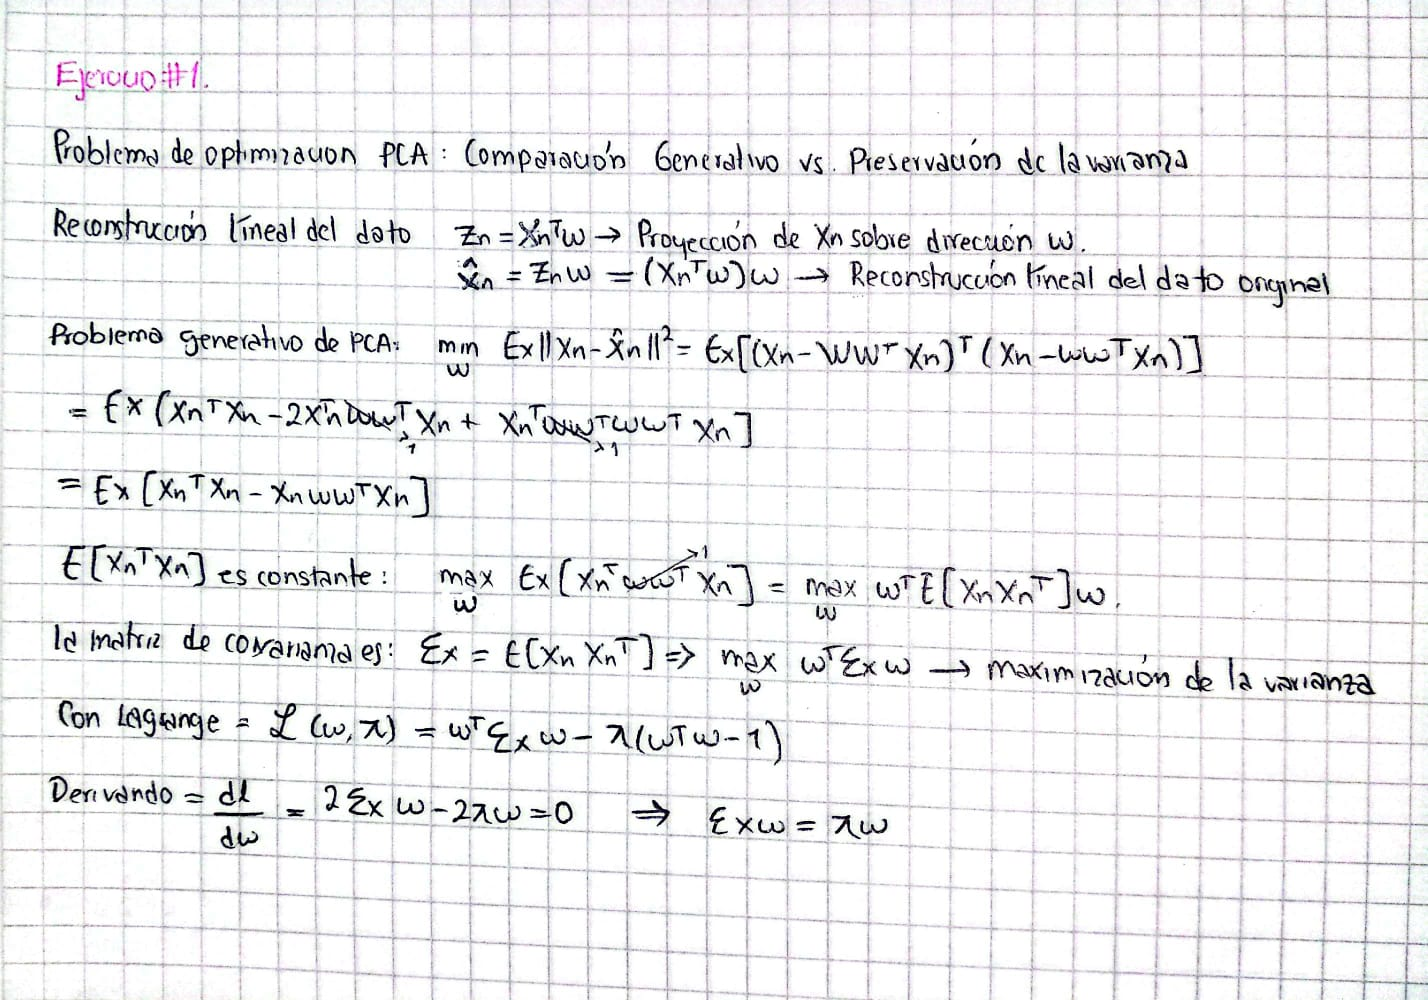

# Ejercicio 2

- Presente un paralelo entre el problema de optimización de PCA y el de Kernel PCA.


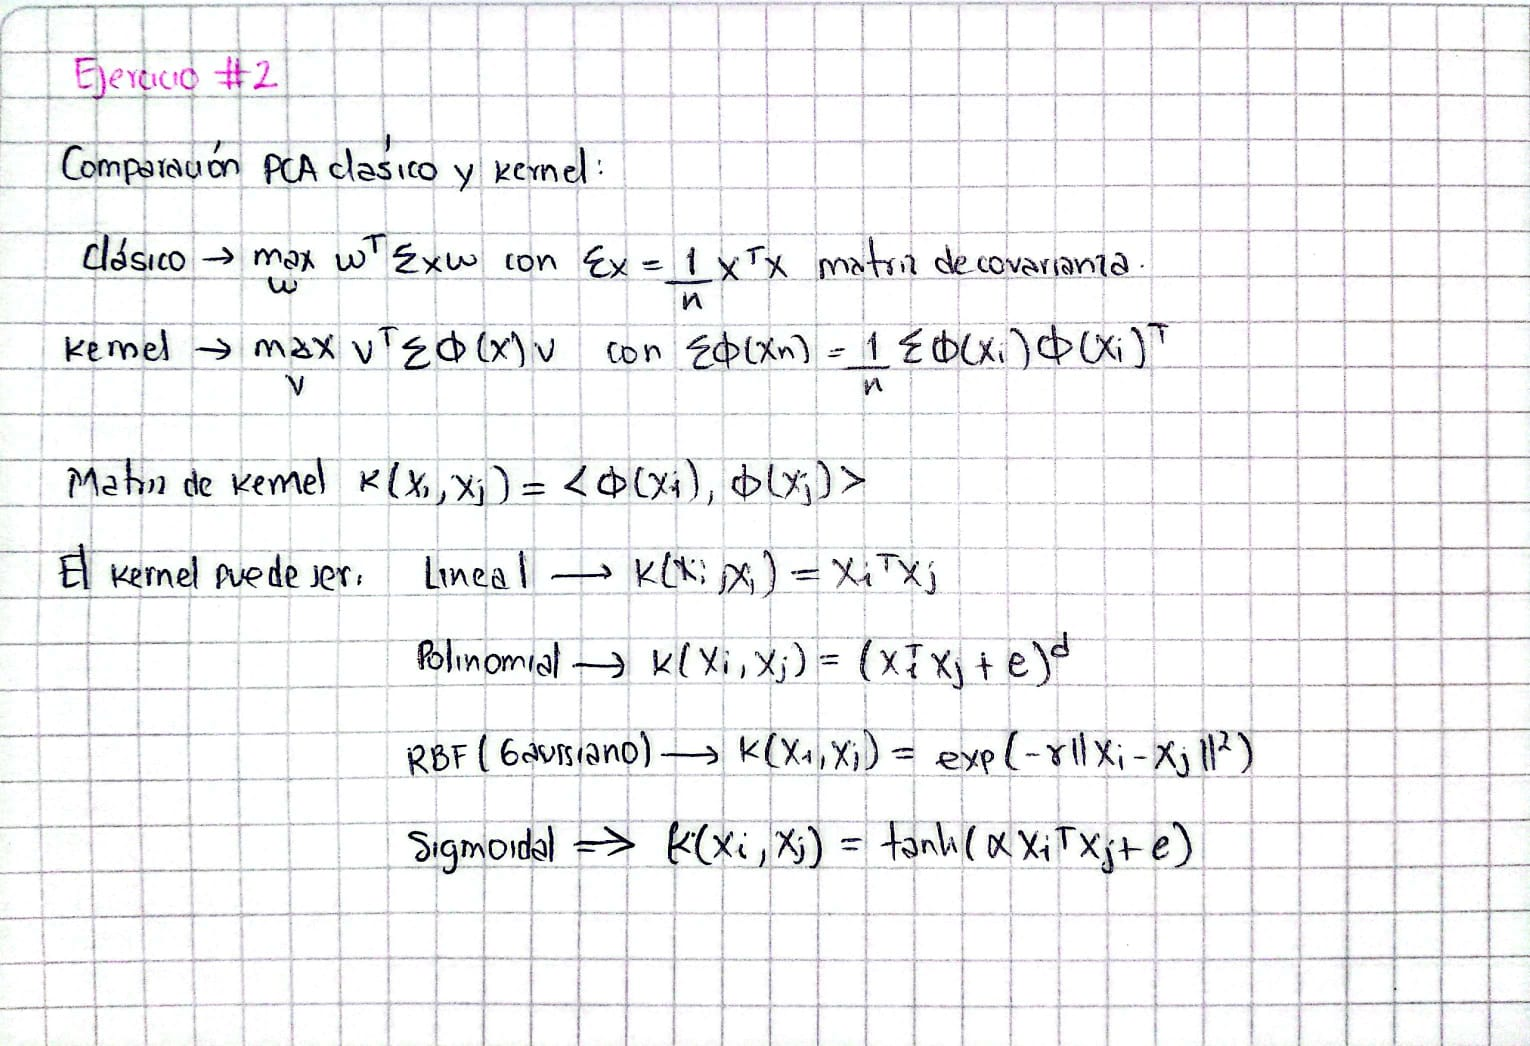

# Ejercicio 3



1.  Consulte en que consiste el algoritmo [eigenfaces](https://direct.mit.edu/jocn/article/3/1/71/3025/Eigenfaces-for-Recognition). Compare el modelo de eigenfaces para reducción de dimensión con el algoritmo PCA. Aplique eigenfaces a Mnist sobre el conjunto `X_train` y grafique las dos primeras dimensiones con las imagenes originales sobre cada punto proyectado, y presente las cinco primeras "eigenfaces" en dibujo tipo imagen.

2. Utilizando la base de datos muestreada Mnist en `X_train` y `y_train`, realice una análisis comparativo en términos del coeficiente de silueta del agrupamiento de los datos a 2 dimensiones utilizando kmeans. Considere los métodos: PCA, kernel PCA rbf, t-SNE y UMAP. Utilice la librería [RAPIDS](https://rapids.ai/) a la hora de implementar los algoritmos, en caso de estar disponibles.


In [46]:
#Cargar fashion mnist
mnist = keras.datasets.mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X = X_train.reshape(X_train.shape[0], -1)/255. ; y = y_train
print(X.shape,y.shape)

(60000, 784) (60000,)


In [47]:
#Se submuestrea para facilidad en cálculos
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.98,random_state=123)
print(X_train.shape,y_train.shape)

(1200, 784) (1200,)


## Parte 1: Eigenfaces

In [48]:
red = PCA(n_components=0.9)
Z = red.fit_transform(X_train)

#Graficar 2D con imágenes originales
#img_w y img_h representan la resolución original de los datos
def plot_mnist_2d(Z,images,img_w=28,img_h=28,zoom=0.5,cmap='jet'):
    fig, ax = plt.subplots(figsize=(10,6))
    for i in range(Z.shape[0]):
        #print('img',i+1,'/',Z.shape[0])
        image = images[i].reshape((img_w, img_h))
        im = OffsetImage(image, zoom=zoom,cmap=cmap)
        ab = AnnotationBbox(im, (Z[i,0], Z[i,1]), xycoords='data', frameon=False)
        ax.add_artist(ab)
        ax.update_datalim([(Z[i,0], Z[i,1])])
        ax.autoscale()

<Figure size 1000x500 with 0 Axes>

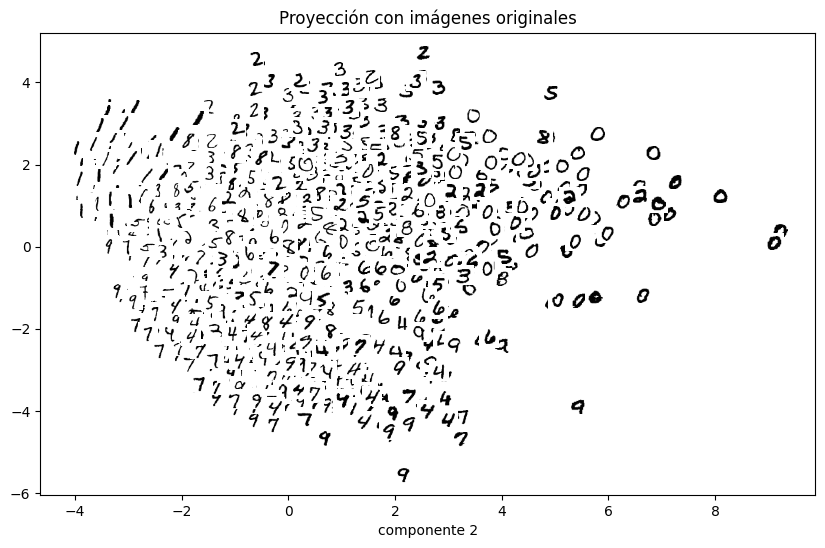

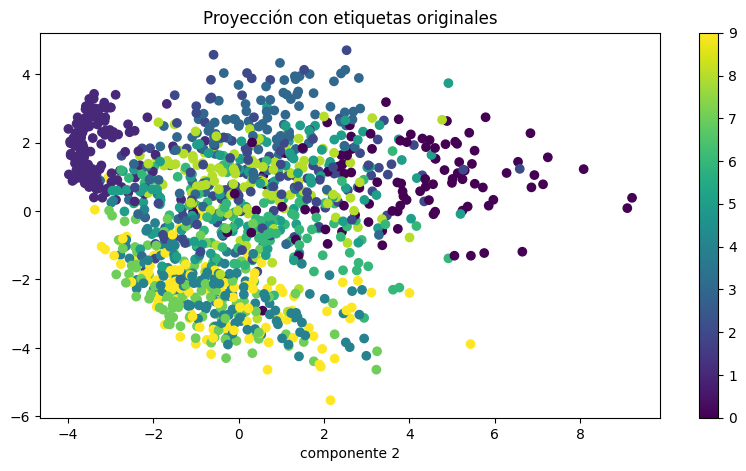

In [49]:
plt.figure(figsize=(10,5))
plot_mnist_2d(Z,X_train,img_w=28,img_h=28,zoom=0.5,cmap='binary')
plt.xlabel('componente 1'); plt.xlabel('componente 2')
plt.title('Proyección con imágenes originales'); plt.show()

plt.figure(figsize=(10,5))
plt.scatter(Z[:,0],Z[:,1],c=y_train)
plt.xlabel('componente 1'); plt.xlabel('componente 2')
plt.title('Proyección con etiquetas originales')
plt.colorbar(); plt.show()

(80, 784)


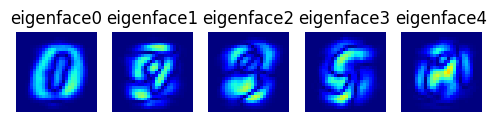

In [50]:
#Graficar componentes como "eigenfaces"
print(red.components_.shape)

n_rows = 1; n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
img_w = 28; img_h = 28 #Resolución imagenes

for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(abs(red.components_[index].reshape(img_w,img_h)),
                    vmin=abs(red.components_).min(), vmax=abs(red.components_).max(),cmap="jet", interpolation="nearest")
        plt.axis('off'); plt.title("eigenface" + str(index), fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5); plt.show()

## Parte 2 : Coefientes de silueta

Dimensiones de los datos reducidos con Kernel PCA (RBF): (1200, 2)


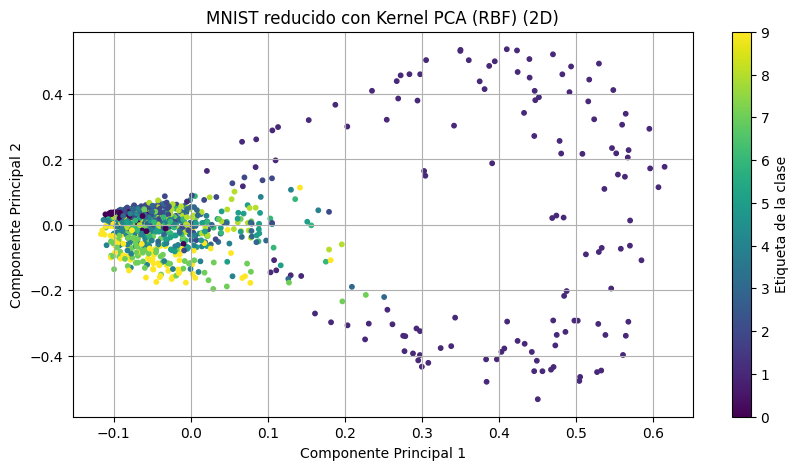

In [51]:
# Aplicar Kernel PCA con kernel RBF
# Se reduce la dimensionalidad a 2 componentes para visualización
kpca_rbf = KernelPCA(n_components=2, kernel="rbf", gamma=0.04)
X_reduced_rbf = kpca_rbf.fit_transform(X_train)
print("Dimensiones de los datos reducidos con Kernel PCA (RBF):", X_reduced_rbf.shape)

#Visualización los datos reducidos
plt.figure(figsize=(10, 5))
plt.scatter(X_reduced_rbf[:, 0], X_reduced_rbf[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('MNIST reducido con Kernel PCA (RBF) (2D)')
plt.xlabel('Componente Principal 1'); plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta de la clase'); plt.grid(True); plt.show()

Dimensiones de los datos reducidos con RAPIDS PCA: (1200, 2)


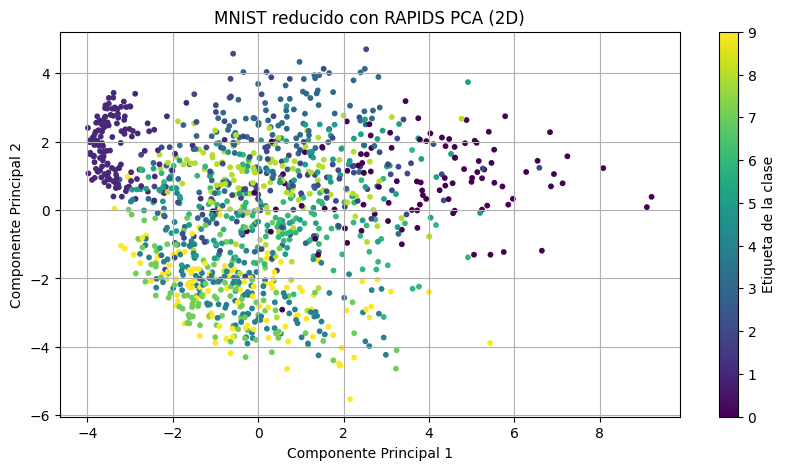

In [52]:
# Aplicar PCA con RAPIDS (cuml)
# Se reduce la dimensionalidad a 2 componentes para visualización
pca_rapids = PCA(n_components=2)
X_reduced_rapids = pca_rapids.fit_transform(X_train)

print("Dimensiones de los datos reducidos con RAPIDS PCA:", X_reduced_rapids.shape)

# Visualizar los datos reducidos
plt.figure(figsize=(10, 5))
plt.scatter(X_reduced_rapids[:, 0], X_reduced_rapids[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('MNIST reducido con RAPIDS PCA (2D)')
plt.xlabel('Componente Principal 1'); plt.ylabel('Componente Principal 2')
plt.colorbar(label='Etiqueta de la clase'); plt.grid(True); plt.show()

Dimensiones de los datos reducidos con UMAP: (1200, 2)


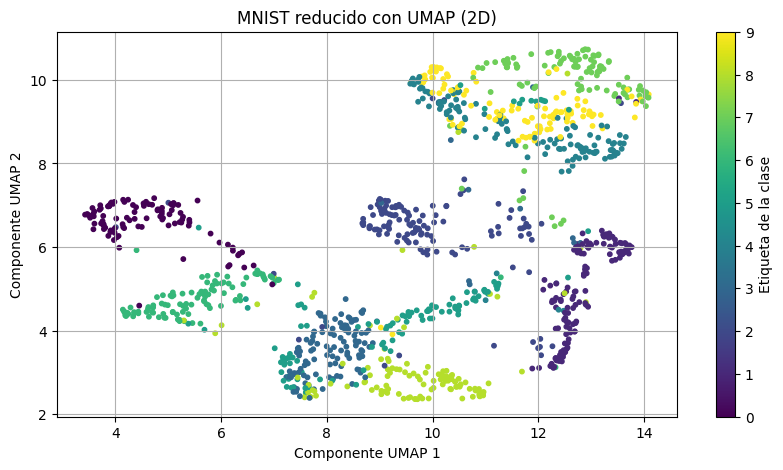

In [53]:
# Aplicar UMAP
# Se redeuce la dimensionalidad a 2 componentes para visualización
umap_model = umap.UMAP(n_components=2, random_state=42)
X_reduced_umap = umap_model.fit_transform(X_train)
print("Dimensiones de los datos reducidos con UMAP:", X_reduced_umap.shape)

# Visualizar los datos reducidos
plt.figure(figsize=(10, 5))
plt.scatter(X_reduced_umap[:, 0], X_reduced_umap[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('MNIST reducido con UMAP (2D)')
plt.xlabel('Componente UMAP 1'); plt.ylabel('Componente UMAP 2')
plt.colorbar(label='Etiqueta de la clase'); plt.grid(True); plt.show()

Dimensiones de los datos reducidos con t-SNE: (1200, 2)


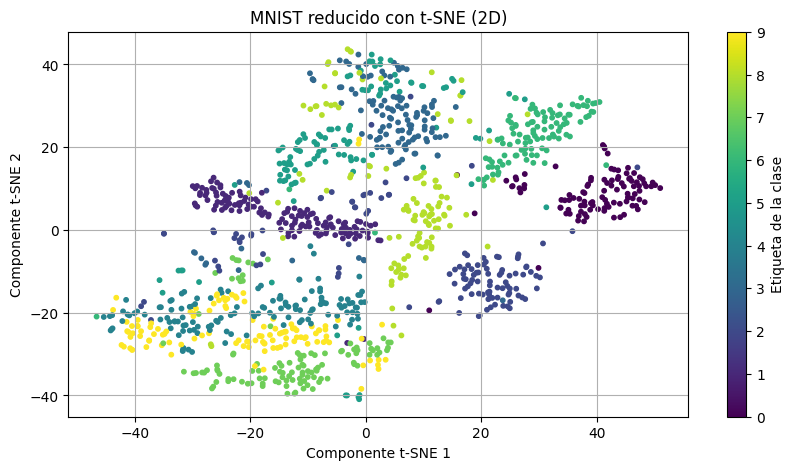

In [54]:
# Aplicar t-SNE
# Se reduce la dimensionalidad a 2 componentes para visualización
tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_train)
print("Dimensiones de los datos reducidos con t-SNE:", X_reduced_tsne.shape)

# Visualizar los datos reducidos
plt.figure(figsize=(10, 5))
plt.scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], c=y_train, cmap='viridis', s=10)
plt.title('MNIST reducido con t-SNE (2D)')
plt.xlabel('Componente t-SNE 1'); plt.ylabel('Componente t-SNE 2')
plt.colorbar(label='Etiqueta de la clase'); plt.grid(True); plt.show()

In [55]:
# Creación de lista con datos reducidos de cada método
reduced_datasets = {
    "PCA (RAPIDS)": X_reduced_rapids,
    "Kernel PCA (RBF)": X_reduced_rbf,
    "t-SNE": X_reduced_tsne,
    "UMAP": X_reduced_umap
}

n_clusters = 10
silhouette_scores = {}

for name, X_reduced in reduced_datasets.items():
    print(f"Aplicando K-Means a los datos reducidos con {name}...")

    # K-Means
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    kmeans.fit(X_reduced)
    labels = kmeans.labels_
    # Calculo del coeficiente de silueta
    score = silhouette_score(X_reduced, labels)
    silhouette_scores[name] = score

    print(f"Coeficiente de Silueta para {name}: {score}"); print("-" * 30)

#Tabla de resultados
scores_df = pd.DataFrame(list(silhouette_scores.items()), columns=['Método de Reducción', 'Coeficiente de Silueta'])
print("\nComparación de Coeficientes de Silueta:")
display(scores_df)

Aplicando K-Means a los datos reducidos con PCA (RAPIDS)...
Coeficiente de Silueta para PCA (RAPIDS): 0.3407706056249719
------------------------------
Aplicando K-Means a los datos reducidos con Kernel PCA (RBF)...
Coeficiente de Silueta para Kernel PCA (RBF): 0.4713366262681198
------------------------------
Aplicando K-Means a los datos reducidos con t-SNE...
Coeficiente de Silueta para t-SNE: 0.42850378155708313
------------------------------
Aplicando K-Means a los datos reducidos con UMAP...
Coeficiente de Silueta para UMAP: 0.48111817240715027
------------------------------

Comparación de Coeficientes de Silueta:


,Método de Reducción,Coeficiente de Silueta
0,PCA (RAPIDS),0.340771
1,Kernel PCA (RBF),0.471337
2,t-SNE,0.428504
3,UMAP,0.481118
